In [ ]:
# CipherNet

### Objective
##### To embed a message into an image by manipulating some pixels such that the cipher is an image used to encrypt and decrypt the message.

### Tools
##### NumPy, Tensorflow-Keras, Matplotlib, Pillow and Resize-Image

### Procedure

# - `Designing` and training a neural network comprising of encoder and decoder
# - `Encoder` converts message into tokenized text and embeds it into an image.
# - `Decoder` takes the encoded image and deciphers the tokenized text.
# - `Training` is done using randomly generated images and texts so that the network can function with any type of images.

#### Mounting google drive to my VM on colab

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
cd /gdrive/'My Drive'/CipherNet

/gdrive/My Drive/CipherNet


In [ ]:
!pip install python-resize-image

#### Importing necessary libraries

In [ ]:
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.losses import *
from tensorflow.keras.callbacks import *
from PIL import Image
from resizeimage import resizeimage
import matplotlib.pyplot as plt

#### Defining sizes for the image and message

In [ ]:
#image_shape = (100, 100, 3)
image_shape = (256, 256, 3)
sentence_length = 256
words_maximum = 256

#### Defining Data Generator

In [ ]:
def data_generator(shape_img, length_sentence, maximum_words, batch_size=32):
    while True:
        image_x = np.zeros((batch_size, shape_img[0], shape_img[1], shape_img[2]))
        sentence_x = np.zeros((batch_size, length_sentence))
        image_y = np.zeros((batch_size, shape_img[0], shape_img[1], shape_img[2]))
        sentence_y = np.zeros((batch_size, length_sentence, maximum_words))
        for i in range(batch_size):
            # Creating random image using randint
            img = np.random.randint(0, 256, shape_img) / 255.0
            # Creating random sentence using randint
            sentence = np.random.randint(0, maximum_words, length_sentence)
            # Performing one hot encoding on the random sentence
            one_hot_encoding = np.zeros((len(sentence),maximum_words))
            for j,v in enumerate(sentence):
                one_hot_encoding[j, v] = 1
            image_x[i] = img
            sentence_x[i] = sentence
            image_y[i] = img
            sentence_y[i] = one_hot_encoding
        yield [image_x, sentence_x], [image_y, sentence_y]

#### Defining Model

In [ ]:
# def get_model(shape_img, length_sentence, maximum_words):
#     # Input image with size (100,100)
#     image_input = Input(shape_img)
#     # Input sentence with text length 100
#     sentence_input = Input((length_sentence,))
#     # Embedding the input sentence with output dimension as 100
#     embedded_sentence = Embedding(maximum_words, 100)(sentence_input)
#     # Embedding each character of sentence to a new space with 100 dimension.
#     # Shape of embedded sequence (100, 100)
#     # Reshaping the embedding as (100, 100, 1)
#     flat_embedded_sentence = Flatten()(embedded_sentence)
#     flat_embedded_sentence = Reshape((shape_img[0], shape_img[1], 1))(flat_embedded_sentence)
#     # 2D convolutional layer with kernel size (1,1) and 20 filters activated by ReLu
#     transformed_image_input = Conv2D(20, 1, activation="relu")(image_input)
#     # Attaching embedded sequence to the image in 3rd axis
#     # Shape of tensor (100, 100, 21)
#     encoded_input = Concatenate(axis=-1)([flat_embedded_sentence, transformed_image_input])
#     # Inputting the embedded image to a (1, 1) conv layer with one filter
#     image_output = Conv2D(3, 1, activation='relu', name='image_reconstruction')(encoded_input)
#     # Decoder model
#     decoder = Sequential(name="sentence_reconstruction")
#     decoder.add(Conv2D(1, 1, input_shape=(100, 100, 3)))
#     decoder.add(Reshape((length_sentence, 100)))
#     decoder.add(TimeDistributed(Dense(maximum_words, activation="softmax")))
#     sentence_output = decoder(image_output)
#     # Training specifications
#     model = Model(inputs=[image_input, sentence_input], outputs=[image_output, sentence_output])
#     model.compile('adam', loss=[mean_absolute_error, categorical_crossentropy],
#                   metrics={'sentence_reconstruction': categorical_accuracy})
#     encoder = Model(inputs=[image_input, sentence_input], outputs=[image_output])
#     return model, encoder, decoder

In [ ]:
def get_model(shape_img, length_sentence, maximum_words):
    # Input image with size (100,100)
    image_input = Input(shape_img)
    # Input sentence with text length 100
    sentence_input = Input((length_sentence,))
    # Embedding the input sentence with output dimension as 100
    embedded_sentence = Embedding(maximum_words, 256)(sentence_input)
    # Embedding each character of sentence to a new space with 100 dimension.
    # Shape of embedded sequence (100, 100)
    # Reshaping the embedding as (100, 100, 1)
    flat_embedded_sentence = Flatten()(embedded_sentence)
    flat_embedded_sentence = Reshape((shape_img[0], shape_img[1], 1))(flat_embedded_sentence)
    # 2D convolutional layer with kernel size (1,1) and 20 filters activated by ReLu
    transformed_image_input = Conv2D(20, 1, activation="relu")(image_input)
    # Attaching embedded sequence to the image in 3rd axis
    # Shape of tensor (100, 100, 21)
    encoded_input = Concatenate(axis=-1)([flat_embedded_sentence, transformed_image_input])
    # Inputting the embedded image to a (1, 1) conv layer with one filter
    image_output = Conv2D(3, 1, activation='relu', name='image_reconstruction')(encoded_input)
    # Decoder model
    decoder = Sequential(name="sentence_reconstruction")
    decoder.add(Conv2D(1, 1, input_shape=(256, 256, 3)))
    decoder.add(Reshape((length_sentence, 256)))
    decoder.add(TimeDistributed(Dense(maximum_words, activation="softmax")))
    sentence_output = decoder(image_output)
    # Training specifications
    model = Model(inputs=[image_input, sentence_input], outputs=[image_output, sentence_output])
    model.compile('adam', loss=[mean_absolute_error, categorical_crossentropy],
                  metrics={'sentence_reconstruction': categorical_accuracy})
    encoder = Model(inputs=[image_input, sentence_input], outputs=[image_output])
    return model, encoder, decoder

#### Training specifications

In [ ]:
gen = data_generator(image_shape, sentence_length, words_maximum, 64)
model, encoder, decoder = get_model(image_shape, sentence_length, words_maximum)
try:
    model.load_weights("best_weights_256.h5")
except:
    model.fit(gen, epochs=512, steps_per_epoch=348, callbacks=[
        ModelCheckpoint("best_weights_256.h5",monitor="loss",
                        verbose=1,
                        save_weights_only=True,
                        save_best_only=True)]
    )

#### Image Resizing function

In [ ]:
def adjust_size_image(img,d1,d2):
  with open(img, 'r+b') as f:
    with Image.open(f) as image:
      cover = resizeimage.resize_cover(image, [d1, d2])
      return cover

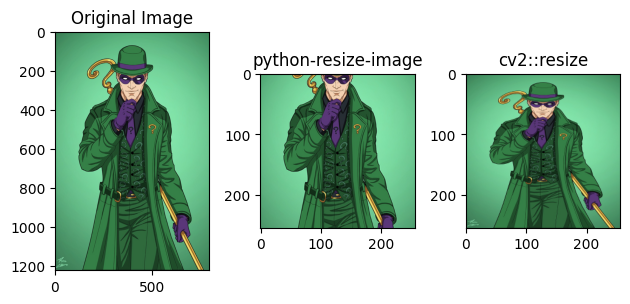

In [ ]:
import cv2
orig_img = plt.imread("The_Riddler.jpg")

img = np.expand_dims(img_to_array(adjust_size_image("The_Riddler.jpg",256,256)) / 255.0, axis=0)

dimensions = (256, 256)
cv2_resized_image = cv2.resize(orig_img, dimensions, interpolation=cv2.INTER_AREA)

width=20
height=20
axes=[]
fig=plt.figure()
axes.append( fig.add_subplot(1, 3, 1) )
axes[-1].set_title("Original Image", fontsize=12)
plt.imshow((orig_img).astype(np.uint8))
axes.append( fig.add_subplot(1, 3, 2) )
axes[-1].set_title("python-resize-image", fontsize=12)
plt.imshow((img[0,:,:,:]* 255).astype(np.uint8))
axes.append( fig.add_subplot(1, 3, 3) )
axes[-1].set_title("cv2::resize", fontsize=12)
plt.imshow((cv2_resized_image).astype(np.uint8))
fig.tight_layout()
plt.show()

#### Choosing the image to send the secret message

In [ ]:
img = np.expand_dims(img_to_array(adjust_size_image("The_Riddler.jpg",256,256)) / 255.0, axis=0)

#### ASCII Encoding the raw message

In [ ]:
raw_message = 'Riddle me this- "What has no hands but might knock on your door, and you better open it if it does?" !@##$$%^&**(())'
raw_message = raw_message.ljust(256)
ascii_message = np.zeros((1, sentence_length))
for i, a in enumerate(raw_message.encode("ascii")):
    ascii_message[0, i] = a

#### Embedding the message into the image using encoder

In [ ]:
embedded_image = encoder.predict([img, ascii_message])

#### Predicting the message from embedded image using decoder

In [ ]:
prediction = decoder.predict(embedded_image)

1/1 [==============================] - 0s 66ms/step


#### Displaying the original image and embedded image(cipher)

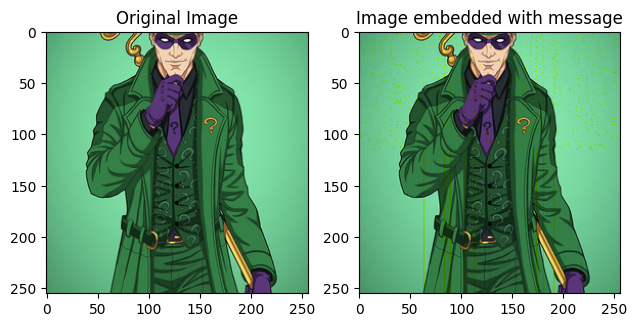

In [ ]:
width=20
height=20
axes=[]
fig=plt.figure()
axes.append( fig.add_subplot(1, 2, 1) )
axes[-1].set_title("Original Image", fontsize=12)
plt.imshow((img[0,:,:,:]* 255).astype(np.uint8))
axes.append( fig.add_subplot(1, 2, 2) )
axes[-1].set_title("Image embedded with message", fontsize=12)
plt.imshow((embedded_image[0,:,:,:]* 255).astype(np.uint8))
fig.tight_layout()
plt.show()

#### ASCII Decoding the message extracted from the embedded image

In [ ]:
print(''.join(chr(int(a)) for a in prediction[0].argmax(-1)))

Riddle me this- "What has no hands but might knock on your door, and you better open it if it does?" !@##$$%^&**(())                                                                                                                                            


In [ ]:
#encoder.save('encrypt_encoder_256.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
#decoder.save('encrypt_decoder_256.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
encoder = load_model('encrypt_encoder_256.h5')
decoder = load_model('encrypt_decoder_256.h5')

Experiment with CV2

In [ ]:
import cv2
orig_img = plt.imread("The_Riddler.jpg")
dimensions = (256, 256)
img = np.expand_dims(cv2.resize(orig_img, dimensions, interpolation=cv2.INTER_AREA) / 255.0, axis=0)

In [ ]:
#raw_message = 'Riddle me this- "What has no hands but might knock on your door, and you better open it if it does?" !@##$$%^&**(())'
raw_message = "Test"
raw_message = raw_message.ljust(256)
ascii_message = np.zeros((1, sentence_length))
for i, a in enumerate(raw_message.encode("ascii")):
    ascii_message[0, i] = a

In [ ]:
embedded_image = encoder.predict([img, ascii_message])

1/1 [==============================] - 0s 28ms/step


In [ ]:
prediction = decoder.predict(embedded_image)

1/1 [==============================] - 0s 24ms/step


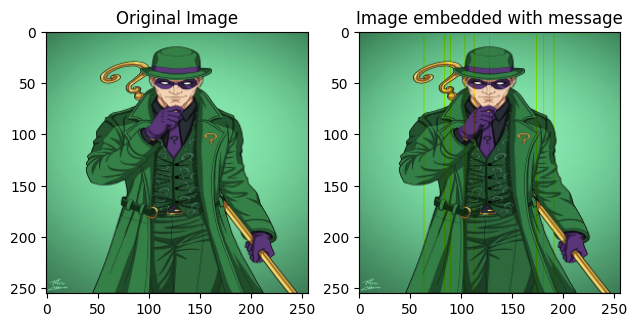

In [ ]:
width=20
height=20
axes=[]
fig=plt.figure()
axes.append( fig.add_subplot(1, 2, 1) )
axes[-1].set_title("Original Image", fontsize=12)
plt.imshow((img[0,:,:,:]* 255).astype(np.uint8))
axes.append( fig.add_subplot(1, 2, 2) )
axes[-1].set_title("Image embedded with message", fontsize=12)
plt.imshow((embedded_image[0,:,:,:]* 255).astype(np.uint8))
fig.tight_layout()
plt.show()

In [ ]:
print(''.join(chr(int(a)) for a in prediction[0].argmax(-1)))

Test                                                                                                                                                                                                                                                            


In [ ]:
cv2.imwrite("experiment_write.jpg", (embedded_image[0,:,:,::-1]* 255).astype(np.double))

True

In [ ]:
ls

best_weights_256.h5  encrypt_decoder_256.h5  experiment_write.jpg
best_weights.h5      encrypt_encoder_256.h5  The_Riddler.jpg


In [ ]:
retrieved_img = plt.imread("experiment_write.jpg")

In [ ]:
retrieved_img.shape

(256, 256, 3)

In [ ]:
retrieved_img = np.expand_dims(retrieved_img/255.0, axis=0)
prediction = decoder.predict(retrieved_img)
result = ''.join(chr(int(a)) for a in prediction[0].argmax(-1))
result

1/1 [==============================] - 0s 24ms/step


'Test                                                                  Q                                                                                                      qqó        û  ô      ûôô    ôôô                                                    '